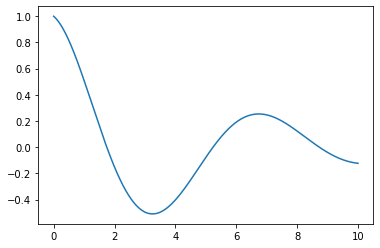

In [11]:
# Reference: https://hal.inria.fr/inria-00179732/document

import numpy as np
from scipy import integrate
import sympy
from matplotlib import pyplot as plt
from IPython.display import display

%matplotlib inline

# set up a sum of coefficients to estimate

N = 1
T = 10
alpha_real = [-0.2, -0.2]
alpha_imag = [0.9, -0.9]
times = np.linspace(0, T, 10000)
signal = sum([np.exp((alpha_real[i] + 1j * alpha_imag[i]) * times) for i in range(N)])
plt.plot(times, signal.real)

In [12]:
# set up Laplace domain matrix equations

s = sympy.Symbol('s')
y = sympy.Function('y')(s)
v = sympy.Symbol('v')

fn_d = lambda s, y: (s**(N+1) * y)
fn_d_ij = lambda i, j: sympy.diff(fn_d(s, y), s, N+i+1)
fn_a = lambda j: lambda s, y: (s**(N-j) * y)
fn_a_ij = lambda i, j: sympy.diff(fn_a(j)(s, y), s, N+i+1)

D = (sympy.expand(sympy.Matrix(N, 1, fn_d_ij)/s**v))
A = (sympy.expand(sympy.Matrix(N, N, fn_a_ij)/s**v))

In [13]:
repr(A[0])

's*s**(-v)*Derivative(y(s), (s, 2)) + 2*s**(-v)*Derivative(y(s), s)'

In [14]:
def ilaplace(sym):
    # takes in a symbolic of the form s^(j-v) y^(i)
    # returns a function that takes in the time-domain signal and returns 
    return

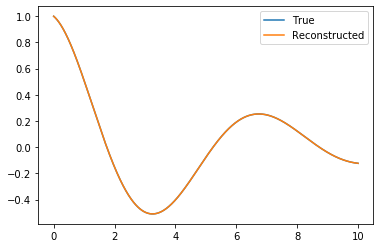

In [17]:
# set up and solve the matrix equation

fact = np.math.factorial

A = np.zeros((N, N), dtype='complex')
d = np.zeros(N, dtype='complex')

v = N+2

def permute(n, k):
    # useful because it's the coefficient on the 'k'th derivative of s^n
    assert n >= k, "permute got a bad value"
    return fact(n)/fact(n - k)

def choose(n, k):
    # useful because product rule works
    assert n >= k, "choose got a bad value"
    return fact(n)/(fact(k)*fact(n - k))

# set up d

for i in range(1,N+1):
    for k in range(N+2):
        to_integrate = (T - times)**(v-N+k-2) * times**(N+i-k) * signal
        integral = integrate.simps(to_integrate, times)
        d[i-1] += choose(N+i, k) * permute(N+1, k) * (-1)**(N+i-k)/fact(v-N+k-2) * integral
        
# set up A
for i in range(1,N+1):
    for j in range(1,N+1):
        for k in range(N+2-j):
            to_integrate = (T - times)**(v-N+j+k-2) * times**(N+i-k) * signal
            integral = integrate.simps(to_integrate, times)
            A[i-1][j-1] += choose(N+i, k) * permute(N+1-j, k) * (-1)**(N+i-k)/fact(v-N+j+k-2) * integral
            
# d = A*theta
theta = np.linalg.inv(A).dot(d)
theta = np.hstack((1, -theta))
alpha = np.roots(theta)

reconstructed = sum([np.exp(alpha[i] * times) for i in range(N)])

plt.plot(times, signal.real, label='True')
plt.plot(times, reconstructed.real, label='Reconstructed')
plt.legend()